# Fused Layers in Triton

## Setup

In [1]:
%pip install --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/ triton-nightly==3.0.0.post20240626041721

Looking in indexes: https://pypi.org/simple, https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["KERAS_BACKEND"] = "torch"
os.environ["DISABLE_TORCH_COMPILE"] = "true"
os.environ["TRITON_PRINT_AUTOTUNING"] = "1"

Check the installed triton version.

In [3]:
import triton

assert triton.__version__ == "3.0.0", f"Expected Triton to have a version of 3.0.0, but found {triton.__version__}"

Import other needed stuff.

In [4]:
import torch
import triton.language as tl

## Generic Autotune Config

In [5]:
def get_autotune_config():
    return [
        triton.Config({}, num_warps=1),
        triton.Config({}, num_warps=2),
        triton.Config({}, num_warps=4),
        triton.Config({}, num_warps=8),
        triton.Config({}, num_warps=16),
        triton.Config({}, num_warps=32),
    ]

## Fused Layer Norm with Quantization

We want to fuse the RMSNorm and the quantization into one layer.

Recall that the RMSNorm is defined to be
$$
\frac{\mathbf{X}}{\mathrm{RMS}(\mathbf{X})}\odot \mathbf{G} + \mathbf{B}
$$
where $\mathbf{X}$ is the input tensor, $\mathbf{G}$ is the 'gain' tensor (gamma in the original LayerNorm paper), and $\mathbf{B}$ is the bias tensor.

### Baseline Spec

Define the spec that we will be implementing in Triton.

In [6]:
def quant_rms_norm_baseline(x: torch.Tensor, gain, bias, epsilon):
    dim = x.shape[-1]
    scale = dim**0.5

    x_norm = torch.nn.functional.normalize(x, p=2, eps=1e-5, dim=-1) * scale
    if gain is not None:
        x_norm *= gain
    if bias is not None:
        x_norm += bias

    scale = 127.0 / torch.unsqueeze(torch.max(torch.abs(x_norm), dim=-1).values.clamp_(epsilon), -1)
    y = torch.clip(torch.round(x_norm * scale), -128, 127) / scale

    # return x_norm + (y - x_norm).detach()  # This includes backward pass
    return y

### Forward Pass

#### Function Definitions

First define the kernel.

In [7]:
# ruff: noqa: N803
@triton.autotune(
    configs=get_autotune_config(),
    key=["N", "HAS_BIAS"],
)
@triton.jit
def quant_rms_norm_fwd_kernel(
    # fmt: off
    # Pointers to arrays
    x_ptr, y_ptr, gain_ptr, bias_ptr, rrms_ptr,
    # Strides
    stride_x_row,  # How much to increase the pointer when moving by 1 row
    stride_y_row,
    # Some constants
    N,  # Number of columns in X
    EPSILON,  # To avoid division by zero
    # Meta-parameters
    BLOCK_SIZE_N: tl.constexpr,
    HAS_GAIN: tl.constexpr,
    HAS_BIAS: tl.constexpr
    # fmt: on
):
    """
    Forward kernel.

    Performs RMSNorm on ``X``, followed by 8-bit quantization.
    """

    # Map the PID to the row of X that should be loaded
    pid = tl.program_id(0)
    base_x = pid * stride_x_row
    offsets = tl.arange(0, BLOCK_SIZE_N)
    mask = offsets < N
    x = tl.load(x_ptr + base_x + offsets, mask=mask, other=0.0).to(tl.float32)  # Load in higher precision

    # Compute reciprocal root mean square (rrms)
    mean_of_squares = tl.sum(x * x, axis=0) / N
    rrms = 1 / tl.sqrt(mean_of_squares + EPSILON)
    tl.store(rrms_ptr + pid, rrms)  # We add PID since that is the row that the RRMS is corresponding to

    # Normalize
    x_hat = x * rrms

    # Apply gain and bias
    y = x_hat

    if HAS_GAIN:
        gain = tl.load(gain_ptr + offsets, mask=mask).to(tl.float32)
        y = y * gain
    if HAS_BIAS:
        bias = tl.load(bias_ptr + offsets, mask=mask).to(tl.float32)
        y = y + bias

    # Apply 8-bit quantization
    scale = 127.0 / tl.maximum(tl.max(tl.abs(y), 0), EPSILON)
    y = tl.extra.cuda.libdevice.round(y * scale)  # TODO: This is CUDA only... can we generalize this?
    y = tl.maximum(tl.minimum(y, 127), -128) / scale  # The nested max and min creates the clamp/clip function

    # Write output
    base_y = pid * stride_y_row
    tl.store(y_ptr + base_y + offsets, y, mask=mask)

Then define the companion function that handles checking and allocation of tensors.

In [8]:
# ruff: noqa: N806, S101
def quant_rms_norm_fwd(x: torch.Tensor, gain, bias, epsilon):
    """
    Forward pass.

    Performs RMSNorm on ``X``, followed by 8-bit quantization.

    Requires CUDA.
    """

    assert x.ndim == 2  # TODO: Support other ndim values?

    # Get dimensions
    M, N = x.shape

    # Validate that the input is OK
    assert x.stride(-1) == 1

    if gain is not None:
        assert gain.shape == (N,)
        assert gain.stride(-1) == 1
    if bias is not None:
        assert bias.shape == (N,)
        assert bias.stride(-1) == 1

    # Allocate output
    y = torch.empty_like(x, dtype=x.dtype)
    rstd = torch.empty((M,), dtype=torch.float32, device="cuda")

    # Enqueue fused kernel if less than 64KiB per feature
    MAX_FUSED_SIZE = 65536 // x.element_size()
    BLOCK_SIZE_N = min(MAX_FUSED_SIZE, triton.next_power_of_2(N))
    if N > BLOCK_SIZE_N:
        raise RuntimeError("This layer norm doesn't support feature dim >= 64KiB.")

    # Run the kernel
    with torch.cuda.device(x.device.index):
        quant_rms_norm_fwd_kernel[(M,)](
            # fmt: off
            # Pointers to arrays
            x, y, gain, bias, rstd,
            # Strides
            x.stride(0),
            y.stride(0),
            # Some constants
            N,  # Number of columns in X
            epsilon,  # To avoid division by zero
            # Meta-parameters
            BLOCK_SIZE_N,
            gain is not None,
            bias is not None
            # fmt: on
        )

    # Return stuff
    return y, rstd

#### Testing the Functions

First define the array that we want to normalize and quantize.

In [9]:
import numpy as np

np.random.seed(8192)

In [10]:
x = torch.tensor(np.random.random((10, 10)), device="cuda")
x

tensor([[0.2693, 0.6153, 0.0975, 0.0927, 0.7301, 0.5821, 0.6097, 0.6101, 0.1207,
         0.2466],
        [0.0462, 0.3005, 0.3514, 0.1330, 0.1475, 0.0314, 0.6199, 0.1457, 0.2693,
         0.4847],
        [0.3966, 0.8817, 0.8379, 0.5626, 0.8726, 0.2629, 0.5891, 0.9908, 0.6995,
         0.6098],
        [0.3702, 0.8369, 0.8916, 0.0165, 0.0878, 0.0137, 0.9819, 0.1413, 0.0624,
         0.9837],
        [0.6199, 0.2864, 0.0849, 0.0382, 0.4834, 0.8644, 0.3387, 0.7978, 0.3520,
         0.9041],
        [0.0204, 0.2730, 0.3259, 0.5211, 0.5283, 0.8570, 0.3380, 0.8175, 0.1245,
         0.7295],
        [0.0803, 0.6749, 0.3077, 0.3218, 0.2434, 0.0056, 0.6843, 0.9604, 0.0744,
         0.2986],
        [0.3991, 0.8103, 0.2235, 0.7061, 0.8713, 0.6701, 0.5355, 0.8366, 0.8714,
         0.0558],
        [0.2335, 0.5846, 0.8606, 0.0053, 0.0329, 0.1382, 0.9652, 0.8446, 0.1085,
         0.9076],
        [0.7014, 0.0256, 0.8586, 0.4920, 0.8743, 0.7849, 0.7285, 0.6576, 0.2997,
         0.9676]], device='c

Get the baseline result.

In [11]:
baseline_output = quant_rms_norm_baseline(x, None, None, 1e-5)
baseline_output = np.array(baseline_output.cpu().detach())
baseline_output

array([[0.58130424, 1.32339475, 0.21025898, 0.1978908 , 1.57075826,
        1.2491857 , 1.31102658, 1.31102658, 0.25973168, 0.53183154],
       [0.1410979 , 0.97200773, 1.12878317, 0.42329369, 0.47032632,
        0.09406526, 1.99104808, 0.47032632, 0.86226492, 1.55207685],
       [0.564153  , 1.24998606, 1.18361512, 0.79645129, 1.23892424,
        0.376102  , 0.84069859, 1.40485159, 0.99556412, 0.86282224],
       [0.61997093, 1.39493459, 1.48534702, 0.02583212, 0.14207667,
        0.02583212, 1.64033975, 0.2324891 , 0.10332849, 1.64033975],
       [1.10381108, 0.50749935, 0.1522498 , 0.06343742, 0.86274889,
        1.53518553, 0.60899922, 1.42099818, 0.6216867 , 1.61131043],
       [0.0382828 , 0.51043732, 0.61252478, 0.98259183, 0.99535277,
        1.62063848, 0.63804664, 1.54407288, 0.22969679, 1.37818075],
       [0.17716222, 1.4334034 , 0.66033191, 0.69254322, 0.515381  ,
        0.01610566, 1.44950906, 2.04541834, 0.16105656, 0.62812059],
       [0.605363  , 1.23160059, 0.3444306

Compare that with the Triton result.

In [12]:
triton_output, triton_rstd = quant_rms_norm_fwd(x, None, None, 1e-5)
triton_output = np.array(triton_output.cpu())
triton_output

Triton autotuning for function quant_rms_norm_fwd_kernel finished after 1.36s; best config selected: num_warps: 8, num_ctas: 1, num_stages: 2, maxnreg: None;


array([[0.58129078, 1.32336402, 0.2102541 , 0.19788621, 1.57072186,
        1.24915671, 1.31099617, 1.31099617, 0.25972566, 0.53181922],
       [0.14109062, 0.97195756, 1.12872493, 0.42327183, 0.47030205,
        0.09406041, 1.99094534, 0.47030205, 0.86222041, 1.55199671],
       [0.56414729, 1.24997342, 1.18360317, 0.79644328, 1.23891175,
        0.37609822, 0.84069014, 1.40483749, 0.99555409, 0.86281353],
       [0.61996233, 1.39491534, 1.48532641, 0.02583176, 0.1420747 ,
        0.02583176, 1.64031708, 0.23248588, 0.10332706, 1.64031708],
       [1.1037935 , 0.50749129, 0.15224738, 0.06343641, 0.86273515,
        1.53516114, 0.60898954, 1.42097557, 0.6216768 , 1.61128473],
       [0.03828211, 0.51042819, 0.61251378, 0.98257422, 0.99533492,
        1.6206094 , 0.63803524, 1.54404521, 0.22969268, 1.37815607],
       [0.17715819, 1.43337083, 0.66031688, 0.69252747, 0.5153693 ,
        0.01610529, 1.44947612, 2.04537201, 0.16105291, 0.62810636],
       [0.60535598, 1.23158634, 0.3444266

In [13]:
if np.allclose(triton_output, baseline_output, atol=1e-3):
    print("✅ Triton and Baseline match")
else:
    raise ValueError("❌ Triton and Baseline differ")

✅ Triton and Baseline match


#### Benchmark

Trial when M = 128 and N = 128 for baseline
Trial when M = 128 and N = 128 for triton
Triton autotuning for function quant_rms_norm_fwd_kernel finished after 0.73s; best config selected: num_warps: 1, num_ctas: 1, num_stages: 2, maxnreg: None;
Trial when M = 256 and N = 256 for baseline
Trial when M = 256 and N = 256 for triton
Triton autotuning for function quant_rms_norm_fwd_kernel finished after 0.74s; best config selected: num_warps: 1, num_ctas: 1, num_stages: 2, maxnreg: None;
Trial when M = 384 and N = 384 for baseline
Trial when M = 384 and N = 384 for triton
Triton autotuning for function quant_rms_norm_fwd_kernel finished after 0.73s; best config selected: num_warps: 1, num_ctas: 1, num_stages: 2, maxnreg: None;
Trial when M = 512 and N = 512 for baseline
Trial when M = 512 and N = 512 for triton
Triton autotuning for function quant_rms_norm_fwd_kernel finished after 0.71s; best config selected: num_warps: 1, num_ctas: 1, num_stages: 2, maxnreg: None;
Trial when M = 640 and N

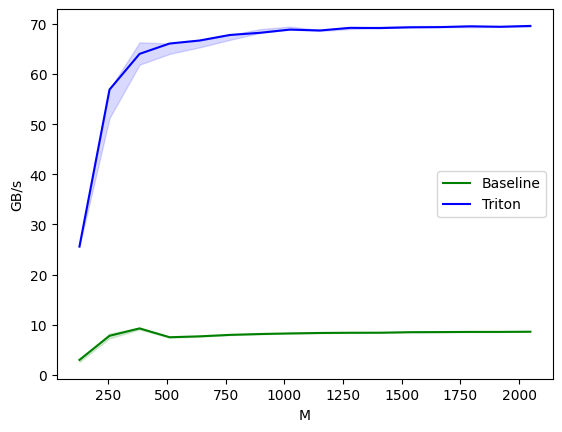

quant-rms-norm-fwd:
         M       N  Baseline     Triton
0    128.0   128.0  3.011765  25.600001
1    256.0   256.0  7.816793  56.888887
2    384.0   384.0  9.290323  63.999998
3    512.0   512.0  7.529412  66.064517
4    640.0   640.0  7.710844  66.666664
5    768.0   768.0  8.000000  67.764705
6    896.0   896.0  8.171987  68.197076
7   1024.0  1024.0  8.291498  68.840338
8   1152.0  1152.0  8.381568  68.662252
9   1280.0  1280.0  8.421052  69.189190
10  1408.0  1408.0  8.431138  69.142856
11  1536.0  1536.0  8.539264  69.293236
12  1664.0  1664.0  8.560349  69.333336
13  1792.0  1792.0  8.591780  69.495842
14  1920.0  1920.0  8.594450  69.397592
15  2048.0  2048.0  8.629971  69.571124


In [14]:
# ruff: noqa: E731

configs = [
    triton.testing.Benchmark(
        x_names=["M", "N"],  # Argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 17)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=["baseline", "triton"],  # Label name for the lines
        line_names=["Baseline", "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="GB/s",  # Label name for the y-axis
        plot_name="quant-rms-norm-fwd",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
]


@triton.testing.perf_report(configs)
def benchmark(M, N, provider):
    print(f"Trial when M = {M} and N = {N} for {provider}")
    x = torch.rand((M, N), device="cuda")

    quantiles = [0.5, 0.2, 0.8]
    if provider == "baseline":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: quant_rms_norm_baseline(x, None, None, 1e-5), quantiles=quantiles
        )
    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: quant_rms_norm_fwd(x, None, None, 1e-5), quantiles=quantiles
        )
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)

### Backward Pass

The backward pass of the raw RMSNorm layer is a little more involved than the forward pass.

Define $\nabla_\mathbf{Y}$ to be the gradient of the outputs (i.e., Vector-Jacobian Products (VJP), error signal, or $\mathrm{d}\,\mathrm{out}$), $\nabla_\mathbf{X}$ be the required change of $\mathbf{X}$, and $\nabla_\mathbf{G}$ and $\nabla_\mathbf{B}$ be defined similarly. Let $\mathbf{\hat{X}} = \frac{\mathbf{X}}{\mathrm{RMS}(\mathbf{X})}$. Then we have

$$
\begin{align*}
    \nabla_\mathbf{X} &= \frac1{\mathrm{RMS}(\mathbf{X})} \left(\nabla_\mathbf{Y} \odot \mathbf{G} - \underbrace{\left(\frac1N \mathbf{\hat{X}} \cdot \left(\nabla_\mathbf{Y} \odot \mathbf{G} \right) \right)}_{\mathbf{C}} \odot \mathbf{\hat{X}}\right) \\
    \nabla_\mathbf{G} &= \sum_{i=1}^{N}\left(\nabla_\mathbf{Y} \odot \mathbf{\hat{X}}\right) & (\text{sum across rows})\\
    \nabla_\mathbf{B} &= \sum_{i=1}^{N}\nabla_\mathbf{Y} & (\text{sum across rows})
\end{align*}
$$

Since we need to sum $\nabla_\mathbf{G}$ and $\nabla_\mathbf{B}$ across the rows, we can use a parallel reduction strategy similar to that described [here](https://triton-lang.org/main/getting-started/tutorials/05-layer-norm.html#backward-pass).